In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from fastdtw import fastdtw
from sklearn.cluster import DBSCAN
import tslearn.metrics as metrics

import seaborn as sns
from scipy.spatial.distance import euclidean
import scipy.cluster.hierarchy
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error

from scipy.spatial.distance import cdist
import warnings#
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)

import matplotlib as mpl
cmap = mpl.colors.ListedColormap(['cornflowerblue',
                                   'tomato','darkorange','mediumseagreen'])

In [2]:
data = pd.read_csv('final.csv') 
data

,Driver,ID,Time(ms),Position_x,Position_y,Position_z,Rotation_x,Rotation_y,Rotation_z,Rotation_w,Speed (km/h),Steering Wheel Position_-1,Steering Wheel Position_1,Gas Pedal Position,Brake Pedal Position,Engine Running,Distance Ahead (meters),Time To Collision (sec),Headway Time (sec)
0,p2,T-74,1,-1.949,0.136,184.128,-0.0006,0.9999,-0.0006,-0.0149,20.92,0.03073,0.730480,0.000000,True,0,0,0,0.054071
1,p2,T-74,2,-1.939,0.136,184.362,-0.0006,0.9999,-0.0006,-0.0162,21.14,0.03315,0.726574,0.000000,True,0,0,0,0.060681
2,p2,T-74,3,-1.927,0.136,184.598,-0.0006,0.9998,-0.0006,-0.0177,21.36,0.03538,0.726574,0.000000,True,0,0,0,0.077581
3,p2,T-74,4,-1.902,0.136,185.078,-0.0006,0.9998,-0.0006,-0.0209,21.81,0.03913,0.726574,0.000000,True,0,0,0,0.076490
4,p2,T-74,5,-1.887,0.136,185.321,-0.0007,0.9997,-0.0006,-0.0226,22.03,0.04101,0.726574,0.000000,True,0,0,0,0.087563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51340,p5,T-41,3026,1063.240,0.136,1314.943,0.0003,-0.6977,-0.0003,0.7164,33.73,-0.00016,0.000000,0.273808,True,0,0,0,-1.730747
51341,p5,T-41,3027,1063.609,0.136,1314.933,0.0003,-0.6976,-0.0003,0.7164,32.98,-0.00074,0.000000,0.142855,True,0,0,0,-1.269858
51342,p5,T-41,3028,1063.972,0.136,1314.923,0.0004,-0.6977,-0.0002,0.7164,32.49,-0.00200,0.000000,0.000000,True,0,0,0,-0.850367
51343,p5,T-41,3029,1064.331,0.136,1314.914,0.0005,-0.6977,-0.0001,0.7164,32.31,-0.00200,0.000000,0.000000,True,0,0,0,-0.390502


In [3]:
data = data.fillna(data.mean()) #goot type of filling missing data
# 把 driver attribute 转化为 int 类型
def diffDrivers(x):
    num=int(x[1:])
        
    return num

data['Driver'] = data['Driver'].map( lambda x: diffDrivers(x))

In [4]:
# data drop
data['Target Variable']=data['Driver'].astype(str)+'_'+data['ID']+'_'+data['Time(ms)'].astype(str)

# data=data.drop(["ID"],axis=1)
# data=data.drop(["ID","Position_y"," Brake Pedal Position "," Gas Pedal Position "," Engine Running "," Distance Ahead (meters)"," Time To Collision (sec) "],axis=1)
# data=data.drop(["ID","Position_x","Position_y","Position_z","Rotation_x","Rotation_z","Steering Wheel Position_-1"," Brake Pedal Position "," Gas Pedal Position "," Engine Running "," Distance Ahead (meters)"," Time To Collision (sec) "],axis=1)

data=data.drop(["ID","Position_y","Rotation_x","Rotation_z","Steering Wheel Position_-1"," Brake Pedal Position "," Gas Pedal Position "," Engine Running "," Distance Ahead (meters)"," Time To Collision (sec) "],axis=1)


In [5]:

### 传统方法
min_max_scaler = preprocessing.MinMaxScaler()
# Selecting all the feature variable columns
matrix = data.loc[:, (data.columns != 'Target Variable')&(data.columns != 'Time(ms)')&(data.columns != 'Driver')]
np_scaled = min_max_scaler.fit_transform(matrix)
data_normalized = pd.DataFrame(np_scaled,columns=matrix.columns,
            index = matrix.index)


In [7]:
# selecting the target variable column
driverAndId = data['Target Variable'].to_frame()

driver_id_time=driverAndId.merge(data['Time(ms)'], how='outer', left_index=True, right_index=True)

driver_id_time=driver_id_time.merge(data['Driver'], how='outer', left_index=True, right_index=True)

# Final normalised dataset
data = driver_id_time.merge(data_normalized, how='outer', left_index=True, right_index=True)
# Selecting all the feature variable columns
matrix = data_normalized.loc[:, (data_normalized.columns != 'Target Variable')&(data_normalized.columns != 'Time(ms)')&(data_normalized.columns != 'Driver')]


In [8]:
new_matrix=matrix

In [9]:
# Applying PCA based dimentionality reduction
pca_new = PCA(n_components=3)
pca_new.fit(new_matrix)

columns = ['pca_%i' % i for i in range(3)]
pca_new_matrix = pd.DataFrame(pca_new.transform(new_matrix), columns=columns, index=new_matrix.index)
final = driverAndId.merge(pca_new_matrix, how='outer', left_index=True, right_index=True)

print (pca_new.explained_variance_ratio_)
print (pca_new.explained_variance_)
print (pca_new.n_components_)

[0.49785733 0.18123537 0.15489138]
[0.34321633 0.12494129 0.10678009]
3


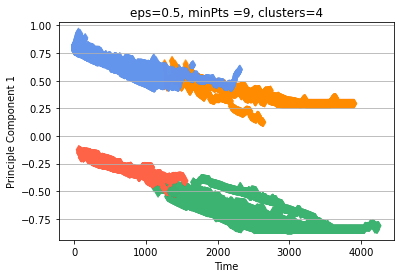

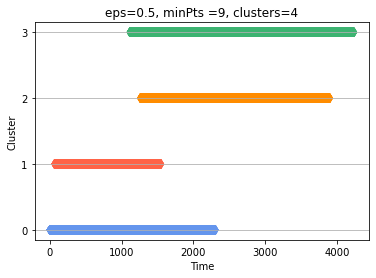

In [10]:
# Get DBSCAN prediction based on most appropriate cluster infered from the graph
eps_value=0.5
min_samples_value=9

dbscan_new_matrix = DBSCAN(eps=eps_value, min_samples = min_samples_value)
dbscanClusters_new_matirx = dbscan_new_matrix.fit_predict(new_matrix)


plt.grid(axis="y",clip_on=True)
plt.scatter(data["Time(ms)"],pca_new_matrix['pca_0'],marker='d', c= dbscanClusters_new_matirx,alpha=0.3,cmap=cmap)
num = len(np.unique(dbscanClusters_new_matirx))
plt.title("eps="+str(eps_value)+", minPts ="+str(min_samples_value)+", clusters="+str(num))
plt.xlabel('Time')
plt.ylabel("Principle Component 1")
# plt.yticks(range(0,2))

plt.show()

plt.grid(axis="y",clip_on=True)
plt.scatter(data["Time(ms)"],dbscanClusters_new_matirx,marker='d',c= dbscanClusters_new_matirx,cmap=cmap)
num = len(np.unique(dbscanClusters_new_matirx))
plt.title("eps="+str(eps_value)+", minPts ="+str(min_samples_value)+", clusters="+str(num))
plt.xlabel('Time')
plt.ylabel('Cluster')
plt.yticks(range(0,4))

plt.show()

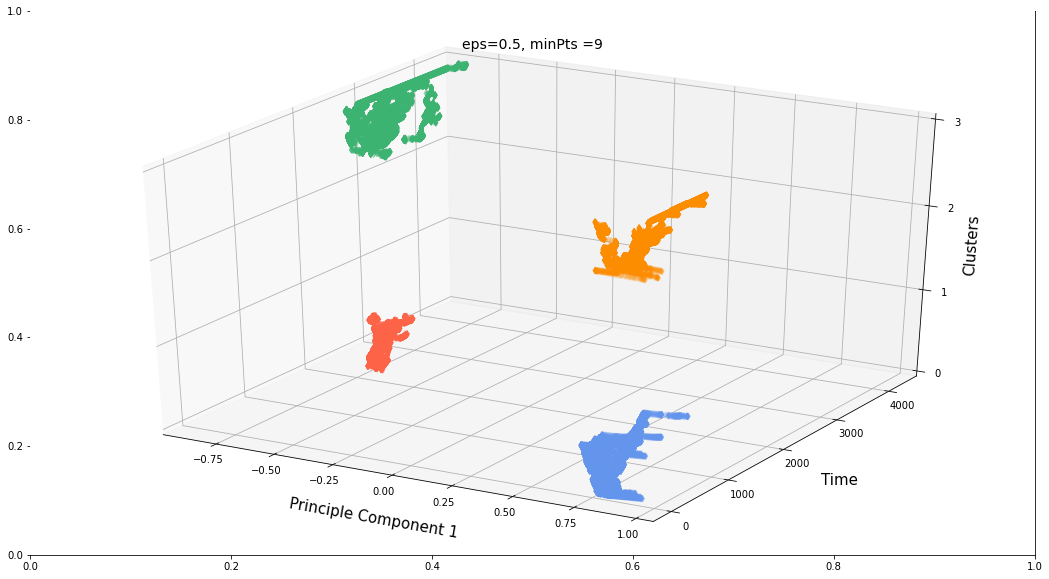

In [11]:
from matplotlib.pyplot import MultipleLocator

eps_value=0.5
min_samples_value=9
fig, ax = plt.subplots(figsize=(18,10))
ax=fig.add_subplot(111, projection='3d')

dbscan_new_matrix = DBSCAN(eps=eps_value, min_samples = min_samples_value)
dbscanClusters_new_matirx = dbscan_new_matrix.fit_predict(new_matrix)


scatter=ax.scatter(pca_new_matrix['pca_0'],data["Time(ms)"],dbscanClusters_new_matirx,marker='d', c= dbscanClusters_new_matirx,alpha=0.3,cmap=cmap)
num = len(np.unique(dbscanClusters_new_matirx))
plt.title("eps="+str(eps_value)+", minPts ="+str(min_samples_value),fontsize=14)

ax.set_ylabel("Time",fontsize=15,labelpad=20)
ax.set_xlabel("Principle Component 1",fontsize=15,labelpad=20)
ax.set_zlabel("Clusters",fontsize=15)

ax.zaxis.set_major_locator(MultipleLocator(1))

ax.set_zlim(0,3,1) 

plt.show()

In [12]:
# Applying PCA based dimentionality reduction
pca = PCA(n_components=3)
pca.fit(matrix)

columns = ['pca_%i' % i for i in range(3)]
pca_df = pd.DataFrame(pca.transform(matrix), columns=columns, index=matrix.index)
final = driverAndId.merge(pca_df, how='outer', left_index=True, right_index=True)

print (pca.explained_variance_ratio_)
print (pca.explained_variance_)
print (pca.n_components_)

[0.49785733 0.18123537 0.15489138]
[0.34321633 0.12494129 0.10678009]
3


----------------------------

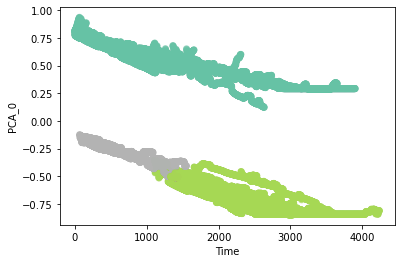

In [13]:
kmeans = KMeans(n_clusters=3).fit(matrix) 
data['km_lables'] = kmeans.labels_
pca_df['KMeans_Labels'] = kmeans.labels_

plt.scatter(data["Time(ms)"],pca_df['pca_0'],c= kmeans.labels_.astype(float),alpha=0.3,cmap="Set2")

plt.xlabel('Time')
plt.ylabel('PCA_0')
plt.show()

--------------------------

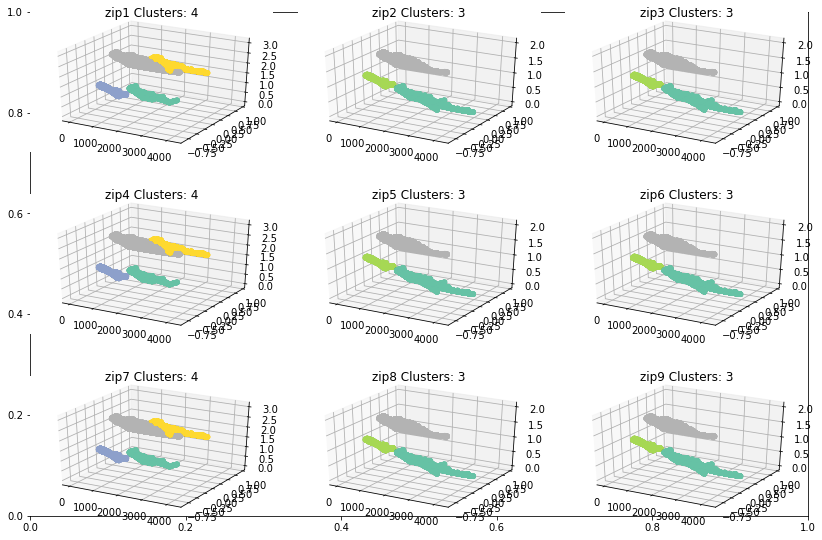

In [14]:
epsValues = [0.125,0.25,0.5,0.125,0.25,0.5,0.125,0.25,0.5]
min_samples_Value = [1,1,1,6,6,6,9,9,9]


# Loop to evaluate DBSCAN on various different hyperparameters and plot it
fig, ax = plt.subplots(figsize=(18,10))
# dists = metrics.cdist_dtw(matrix)

i = 1
for esp, min_samples in zip(epsValues,min_samples_Value):
    # --------这里的 DBSCAN() 默认使用欧式距离，我们要尝试使用不同的距离函数-------
#     dbscan = DBSCAN(eps=esp, min_samples = min_samples,metric='manhattan')
    dbscan = DBSCAN(eps=esp, min_samples = min_samples,metric='chebyshev')
    
#     dbscan = DBSCAN(eps=esp, min_samples = min_samples)
    dbscanClusters = dbscan.fit_predict(pca_df)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.9,
                wspace=0.1, hspace=0.3)

    ax=fig.add_subplot(3,3,i, projection='3d')

    scatter=ax.scatter(data["Time(ms)"], pca_df['pca_0'],dbscanClusters, c=dbscanClusters,cmap="Set2")
    
    num = len(np.unique(dbscanClusters))
    plt.title("zip"+ str(i)+" "+"Clusters: "+str(num))
    i += 1

plt.show()


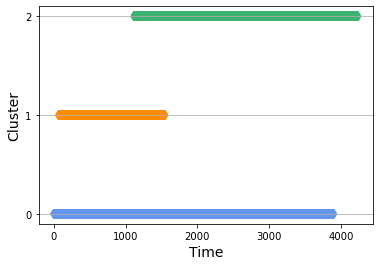

In [15]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(['cornflowerblue',
                                   'darkorange','mediumseagreen'])

# Get DBSCAN prediction based on most appropriate cluster infered from the graph
eps_value=0.5
min_samples_value=9

dbscan = DBSCAN(eps=eps_value, min_samples = min_samples_value)
dbscanClusters = dbscan.fit_predict(pca_df)
labels = dbscanClusters
pca_df['DBSCAN_Labels'] = dbscanClusters


plt.scatter(data["Time(ms)"],dbscanClusters,marker='d',c= dbscanClusters,cmap=cmap)
num = len(np.unique(dbscanClusters))
# plt.title("eps="+str(eps_value)+", minPts ="+str(min_samples_value)+", clusters="+str(num))
plt.xlabel('Time',fontsize=14)
plt.ylabel('Cluster',fontsize=14)
plt.yticks(range(0,3))
plt.grid(axis="y",which='both')

plt.show()

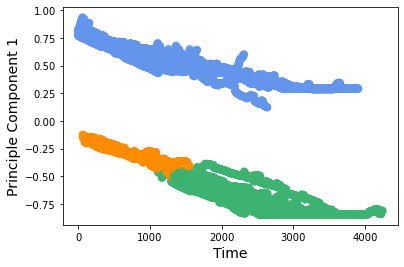

In [16]:
# Get DBSCAN prediction based on most appropriate cluster infered from the graph
eps_value=0.5
min_samples_value=9

dbscan = DBSCAN(eps=eps_value, min_samples = min_samples_value)
dbscanClusters = dbscan.fit_predict(pca_df)
labels = dbscanClusters
pca_df['DBSCAN_Labels'] = dbscanClusters

sizes=40*(data['Driver'].astype(int))

plt.scatter(data["Time(ms)"],pca_df['pca_0'],s=np.pi * 4**2, c= dbscanClusters,alpha=0.3,cmap=cmap)
num = len(np.unique(dbscanClusters))
# plt.title("eps="+str(eps_value)+", minPts ="+str(min_samples_value)+", clusters="+str(num))
plt.xlabel('Time',fontsize=14)
plt.ylabel('Principle Component 1',fontsize=14)
plt.show()